In [2]:
from pydoc import doc
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


class AutoCleaner:
    def __init__(self, path):
        self.path = path
        self.df = pd.read_csv(path)
        self.df_stat = None
        self.cleaning_suggestions = None
        self.temp_df = None
        self.categorical_columns = None

    def describe_data(self, deep: bool = False) -> pd.DataFrame:
        '''
        This function will describe the dataframe and return a dataframe with the following columns:
        Column_Name, missing value percentage, missing values count, unique values count [use full for categorical data types]
        params:
            deep: bool -> if True, will return the full description of the dataframe
                       -> if False, will return a simplified description of the dataframe
        returns: pd.DataFrame
        '''

        if deep:
            return self.df.describe()

        unique_values = self.df.nunique()
        row_size = len(self.df)
        missing_values = self.df.isnull().sum()
        missing_values_percentage = round((missing_values * 100) / row_size, 2)
        self.df_stat = {
            "Column_Name": self.df.columns.values,
            "Unique_Values": unique_values,
            "Data_Types": self.df.dtypes,
            "Missing_Values_Count": missing_values,
            "Missing_Values_Percentage": missing_values_percentage,
        }
        display(pd.DataFrame(self.df_stat))

        return self

    def suggest_cleaning_options(self):
        '''
        This function will suggest cleaning options for the dataframe. 
        (NB: The suggestion is based on the most common patterns from many datasets and further analysis
        may be necessary based on your data) 

        returns: pd.DataFrame
        '''

        if not self.df_stat:
            self.describe_data()

        nan_percentage = []
        imputation_techniques = []
        cols_with_null = []

        # if percentage is greater than 50% then suggest imputation technique as removal else as ModelBased imputation or single Imputation
        for index, percentage in enumerate(self.df_stat["Missing_Values_Percentage"]):
            if percentage > 50:
                cols_with_null.append(self.df_stat["Column_Name"][index])
                nan_percentage.append(percentage)
                imputation_techniques.append("Removal")
            elif percentage != 0:
                cols_with_null.append(self.df_stat["Column_Name"][index])
                nan_percentage.append(percentage)
                imputation_techniques.append("ModelBased or SingleImputation")

        self.cleaning_suggestions = pd.DataFrame({
            "Columns": cols_with_null,
            "Null Percentage": list(filter((0).__ne__, nan_percentage)),
            "Suggested Cleaning Method": imputation_techniques
        })

        display(self.cleaning_suggestions)
        return self

    def handle_missing_values(
            self,
            columns: list = None,
            strategy: str = "mean",
            drop_numerical: list = False,
            drop_non_numerical: list = False,
            axis: int = 1,
            missing_values=np.nan,
#             categorical_columns=None,
    ):
        '''
        This function will handle missing values in the dataframe.
        params:
            `strategy: str` -> the strategy to use for imputation ["mean", "median", "most_frequent", "constant"]
                            -> if no strategy is given, the missing values will be imputed by using SimpleImputer
            `columns: list` -> the columns to impute [None, "all"]
            `in_place: bool` -> if True, will impute the dataframe in place 
            `drop: str` -> if True, will drop the columns with missing values ["row", "column", "None"]
            `missing_values`: -> the different types of missing values could be a list or a single value 
                              -> default is np.nan
            `categorical_columns: List` -> category columns that will be excluded from SimpleImputer

        returns: pd.DataFrame
        '''
        if strategy not in ['mean', 'median', 'most_frequent', 'constant']:
            raise Exception("Invalid argument")
        elif strategy is None:
            strategy = "mean"
            
        if self.temp_df is None:
            self.temp_df = self.df.copy()

        if not columns:
            columns = self.temp_df.columns.tolist()

        if (drop_non_numerical and drop_numerical) and (len(drop_non_numerical) + len(drop_numerical)) == len(columns) == len(self.temp_df.columns):
            print("WARNING: Tried to drop both numerical and non-numerical columns")
#             return self.temp_df

        if drop_numerical:
            self.temp_df.drop(
                drop_numerical,
                axis=axis,
                inplace=True
            )
            columns = [
                col for col in columns if col not in drop_numerical
            ]

        if drop_non_numerical:
            columns = [
                col for col in columns if col not in drop_non_numerical
            ]

            self.temp_df.drop(
                drop_non_numerical,
                axis=axis,
                inplace=True
            )
            columns = self.temp_df.columns.tolist()

        # if strategy:
        self.non_numeric_df = None
        if len(columns) != 0:
                            
            non_numeric_columns = self.temp_df.select_dtypes(
                include=np.object).columns.tolist()
            
            numeric_columns = self.temp_df.select_dtypes(
                include=np.number).columns.tolist()

            if len(non_numeric_columns) != 0:
                
                self.non_numeric_df = self.temp_df[non_numeric_columns]

                self.temp_df.drop(
                    non_numeric_columns,
                    axis="columns",
                    inplace=True
                )

                # null or nan values for non numeric values will be filed by using their mode

                self.non_numeric_df = self.non_numeric_df.fillna(
                    self.non_numeric_df
                    .mode()
                    .iloc[0]
                )

                non_numeric_columns = self.temp_df.select_dtypes(
                    include=np.object).columns.tolist()

            if len(numeric_columns) != 0:
                self.temp_df.replace('?', missing_values, inplace=True)
                imp = SimpleImputer(missing_values=np.NaN, strategy=strategy)
                idf = pd.DataFrame(imp.fit_transform(self.temp_df))
                idf.columns = self.temp_df.columns
                idf.index = self.temp_df.index
                self.temp_df = idf
                self.temp_df = idf.round(decimals=2)
                if self.non_numeric_df is not None:
                    self.temp_df = self.temp_df.join(self.non_numeric_df)
            else:
                print(non_numeric_columns)
                if len(non_numeric_columns) != 0:
                    self.temp_df = self.non_numeric_df
                    # return self.non_numeric_df
            # return self.temp_df
        else:
            print("All columns have been droped")
        return self
        # else:
            # pass

    def plot_missing_values(self):
        '''
            plot missing values from 
        '''
        pass

    def auto_clean(self):
        '''
        This function will automate the cleaning process by finding nan values and removing
        and replacing them by applying the SimpleImputer function and identifying corelation
        between the columns.
        '''
        self.describe_data().suggest_cleaning_options().handle_missing_values(strategy="mean").commit().handle_outliers().detect_categorical_columns().encode_categorical_columns("one-hot").commit()
        self.df.to_csv("cleaned_data.csv", encoding="utf-8", sep=",")
        return self.df

    def handle_outliers(self,
                       lower_quantile
                       ) -> pd.DataFrame:
        '''
        features, label,multiplier=1.5
        '''
        # get both numerical and non-numerical columns
        if self.temp_df is None:
            self.temp_df = self.df.copy()

        numerical_columns = self.temp_df.select_dtypes(
            include=[np.number]).columns.values
        non_numeric_columns = self.temp_df.select_dtypes(
            include=[np.object]).columns.values

        lower = self.temp_df[numerical_columns].quantile(0.25)
        upper = self.temp_df[numerical_columns].quantile(0.75)

        # calculate IQR
        IQR = upper - lower
        # calculate the cut_off
        cut_off = 1.5 * IQR

        lower_bound = lower - cut_off
        upper_bound = upper + cut_off
        updated_outlier = self.temp_df[((self.temp_df[numerical_columns] > lower_bound) | (
            self.temp_df[numerical_columns] < upper_bound))]
        for col in non_numeric_columns:
            updated_outlier[col] = self.temp_df[col]

        return self

    def commit(self):
        self.df = self.temp_df
        return self

    def get_df(self) -> pd.DataFrame:
        return self.df

    def detect_categorical_columns(self, plot: bool = True):
        '''
        This function will detect categorical columns in the dataframe.
        '''
        temp = self.df.copy()
        numerical_columns = temp.select_dtypes(
            include=[np.number]).columns.values
        categorical_columns = []
        
        for col in temp.columns:
            if col not in numerical_columns:
                categorical_columns.append(col)
                temp[col] = temp[col].astype("category")

        if plot:
            for col in categorical_columns:
                labels = temp[col].astype('category').cat.categories.tolist()
                counts = temp[col].value_counts()
                sizes = [counts[var_cat] for var_cat in labels]
                fig1, ax1 = plt.subplots()
                ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
                        shadow=True)  # autopct is show the % on plot
                ax1.axis('equal')
            plt.show()
        self.categorical_columns = categorical_columns
        display(temp[categorical_columns])

        return self

    def encode_categorical_columns(self, encoding_type, replace_map: dict = None):
        '''
        This function will encode categorical columns to numerical values.
        '''
        if self.temp_df is None:
            self.temp_df = self.df.copy()

        if self.categorical_columns is None:
            self.detect_categorical_columns()

        if encoding_type == "replace":
            if replace_map is None:
                for col in self.categorical_columns:
                    labels = self.temp_df[col].astype(
                        'category').cat.categories.tolist()
                    replace_map_comp = {col: {k: v for k, v in zip(
                        labels, list(range(1, len(labels)+1)))}}
                    self.temp_df[col] = self.temp_df[col].replace(
                        replace_map_comp[col]
                    )
                display(self.temp_df)

            else:
                for col in self.categorical_columns:
                    self.temp_df[col].replace(replace_map[col], inplace=True)
                display(self.temp_df)

        elif encoding_type == "one-hot":
            self.temp_df = pd.get_dummies(
                self.temp_df, columns=self.categorical_columns)

        elif encoding_type == "label":
            label_encoder = LabelEncoder()
            for col in self.categorical_columns:
                self.temp_df[col] = label_encoder.fit_transform(
                    self.temp_df[col])

            # self.temp_df = pd.get_dummies(
            #     self.temp_df, columns=self.categorical_columns, prefix=self.categorical_columns)

        else:
            print("Please choose a valid encoding type")

        return self
    

In [19]:
cleaner = AutoCleaner("../data-sets/test.csv")

In [20]:
cleaner.describe_data(deep = True)
cleaner.suggest_cleaning_options()

,Column_Name,Unique_Values,Data_Types,Missing_Values_Count,Missing_Values_Percentage
A,A,8,int64,0,0.0
B,B,5,float64,2,25.0
C,C,6,float64,1,12.5
D,D,3,object,1,12.5
D.1,D.1,3,object,1,12.5


,Columns,Null Percentage,Suggested Cleaning Method
0,B,25.0,ModelBased or SingleImputation
1,C,12.5,ModelBased or SingleImputation
2,D,12.5,ModelBased or SingleImputation
3,D.1,12.5,ModelBased or SingleImputation


In [21]:
cleaner.handle_missing_values(
        strategy="mean",
        axis=1,
        missing_values=np.nan,
    ).temp_df.head()

# cleaner.handle_outliers().temp_df.head()

,A,B,C,D,D.1
0,1.0,2.00,3.0,Good,Good
1,4.0,11.17,6.0,Good,Good
2,7.0,11.17,9.0,Excellent,Excellent
3,10.0,11.00,12.0,Excellent,Fair
4,13.0,14.00,15.0,Excellent,Excellent


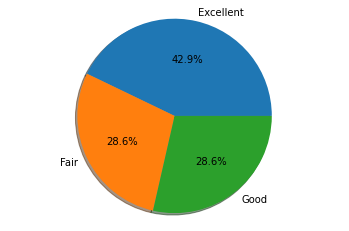

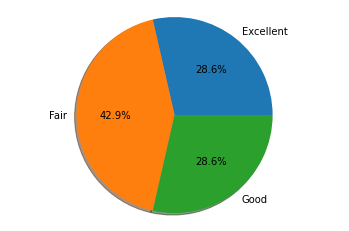

,D,D.1
0,Good,Good
1,Good,Good
2,Excellent,Excellent
3,NaN,NaN
4,Excellent,Excellent
5,Fair,Fair
6,Excellent,Fair
7,Fair,Fair


In [22]:
cleaner.detect_categorical_columns()

In [23]:
cleaner.encode_categorical_columns("one-hot").temp_df.head()

,A,B,C,D_Excellent,D_Fair,D_Good,D.1_Excellent,D.1_Fair,D.1_Good
0,1.0,2.00,3.0,0,0,1,0,0,1
1,4.0,11.17,6.0,0,0,1,0,0,1
2,7.0,11.17,9.0,1,0,0,1,0,0
3,10.0,11.00,12.0,1,0,0,0,1,0
4,13.0,14.00,15.0,1,0,0,1,0,0
